# GraphRAG Knowledge Graph Exploration

This notebook helps you explore the knowledge graph built by GraphRAG 3.0.x.

**Knowledge Graph Stats (10 documents):**
- 147 entities
- 263 relationships
- 32 communities

**Prerequisites:**
- Run `poetry run python -m core.index` to build the knowledge graph
- Ensure output files exist in `output/` directory (*.parquet files)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path

# Set up paths
output_dir = Path("..") / "output"

print(f"📂 Output directory: {output_dir}")
print(f"   Exists: {output_dir.exists()}")

📂 Output directory: ..\output
   Exists: True


## 1. Load Entities

In [2]:
# Load entities (GraphRAG 3.x uses entities.parquet)
entities_df = pd.read_parquet(output_dir / "entities.parquet")

print(f"📊 Total Entities: {len(entities_df)}")
print(f"\n🏷️  Entity Types:")
print(entities_df['type'].value_counts())

entities_df.head()

📊 Total Entities: 147

🏷️  Entity Types:
type
ORGANIZATION    69
EVENT           40
PERSON          31
GEO              7
Name: count, dtype: int64


,id,human_readable_id,title,type,description,text_unit_ids,frequency,degree
0,ab373340-0f09-495d-89b2-745677e9ce36,0,TECHVENTURE INC.,ORGANIZATION,TechVenture Inc. is a mid-sized technology com...,[d6765f07ca5aa131c1aee00597781a0812baff3c5355e...,11,58
1,c4ae6b54-fbf7-4675-9a82-bc9c10371ecb,1,DR. EMILY HARRISON,PERSON,Dr. Emily Harrison is a distinguished figure i...,[d6765f07ca5aa131c1aee00597781a0812baff3c5355e...,13,18
2,ae54f5bf-7f50-4385-9672-f2a73a243364,2,DAVID KUMAR,PERSON,David Kumar is an accomplished and multi-facet...,[d6765f07ca5aa131c1aee00597781a0812baff3c5355e...,16,21
3,0ad8ef81-cb98-4744-bce1-8e87169182a8,3,AMANDA FOSTER,PERSON,Amanda Foster plays a pivotal role in product ...,[d6765f07ca5aa131c1aee00597781a0812baff3c5355e...,8,8
4,972fa2b2-a755-42a9-9d5b-44f2bc0f285e,4,DR. JAMES MITCHELL,PERSON,Dr. James Mitchell is a highly experienced Sen...,[d6765f07ca5aa131c1aee00597781a0812baff3c5355e...,14,10


In [3]:
# Display entities in a table with their types and connection counts
entity_table = entities_df[['title', 'type']].copy()
entity_table.columns = ['Entity', 'Type']

# We'll add connections after building the graph (for now show without)
entity_table = entity_table.sort_values('Type').reset_index(drop=True)
entity_table.index = entity_table.index + 1  # Start index at 1

In [4]:
entity_table.head(20)

,Entity,Type
1,SECURITY HARDENING,EVENT
2,HEALTHCARE INNOVATION FORUM,EVENT
3,SERIES D PLANNING,EVENT
4,STAGING ENVIRONMENT,EVENT
5,AG-UI PROTOCOL,EVENT
6,DISASTER RECOVERY,EVENT
7,INTERNATIONAL EXPANSION EVENT,EVENT
8,DOCKER IMAGE CREATION,EVENT
9,UNIT TESTS,EVENT
10,INTEGRATION TESTS,EVENT


In [5]:
entity_table.tail(15)

,Entity,Type
133,SARAH CHEN,PERSON
134,LISA WANG,PERSON
135,JENNIFER MOORE,PERSON
136,JENNIFER MARTINEZ,PERSON
137,DR. SARAH WILLIAMS,PERSON
138,MARCUS CHEN,PERSON
139,ELENA RODRIGUEZ,PERSON
140,CARLOS MARTINEZ,PERSON
141,DR. STEVEN PARK,PERSON
142,MARGARET WILSON,PERSON


## 2. Load Relationships

In [6]:
# Load relationships (GraphRAG 3.x uses relationships.parquet)
relationships_df = pd.read_parquet(output_dir / "relationships.parquet")

print(f"🔗 Total Relationships: {len(relationships_df)}")
print(f"\n📈 Relationship Types:")
if 'description' in relationships_df.columns:
    print(relationships_df['description'].value_counts().head(10))
else:
    print("No relationship types found")

relationships_df.head()

🔗 Total Relationships: 263

📈 Relationship Types:
description
Jennifer Park reports to Michael Rodriguez                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

,id,human_readable_id,source,target,description,weight,combined_degree,text_unit_ids
0,ef5b2f63-2287-4a68-b54c-22508b2088c7,0,TECHVENTURE INC.,PROJECT ALPHA,TechVenture Inc. is leading Project Alpha to d...,9.0,83,[d6765f07ca5aa131c1aee00597781a0812baff3c5355e...
1,761959c6-b9fb-4777-980a-656008c725e8,1,DR. EMILY HARRISON,PROJECT ALPHA,Dr. Emily Harrison plays a pivotal role in Pro...,26.0,43,[d6765f07ca5aa131c1aee00597781a0812baff3c5355e...
2,2f86d730-0526-4395-bbdc-e30f651b00a4,2,DAVID KUMAR,PROJECT ALPHA,David Kumar plays a crucial role in the develo...,16.0,46,[d6765f07ca5aa131c1aee00597781a0812baff3c5355e...
3,fc9e5cc4-8175-4a41-b3fb-c4715030b204,3,AMANDA FOSTER,PROJECT ALPHA,Amanda Foster manages product requirements and...,8.0,33,[d6765f07ca5aa131c1aee00597781a0812baff3c5355e...
4,f0478f07-e191-4376-b6fd-6b0e1e7f927b,4,DR. JAMES MITCHELL,PROJECT ALPHA,Dr. James Mitchell is a central figure in the ...,13.0,35,[d6765f07ca5aa131c1aee00597781a0812baff3c5355e...


## 3. Visualize Knowledge Graph

Create a network graph visualization of entities and relationships.

In [7]:
# Create a NetworkX graph
G = nx.Graph()

# Add nodes (entities) - GraphRAG 3.x uses 'title' column
for idx, row in entities_df.iterrows():
    G.add_node(row['title'], type=row['type'])

# Add edges (relationships) - limit to top relationships for visualization
top_relationships = relationships_df.head(50)  # Limit for readability
for idx, row in top_relationships.iterrows():
    if 'source' in row and 'target' in row:
        G.add_edge(row['source'], row['target'], relationship=row.get('description', 'related'))

print(f"📊 Graph Stats:")
print(f"   Nodes: {G.number_of_nodes()}")
print(f"   Edges: {G.number_of_edges()}")
if G.number_of_nodes() > 1:
    print(f"   Density: {nx.density(G):.4f}")

📊 Graph Stats:
   Nodes: 147
   Edges: 50
   Density: 0.0047


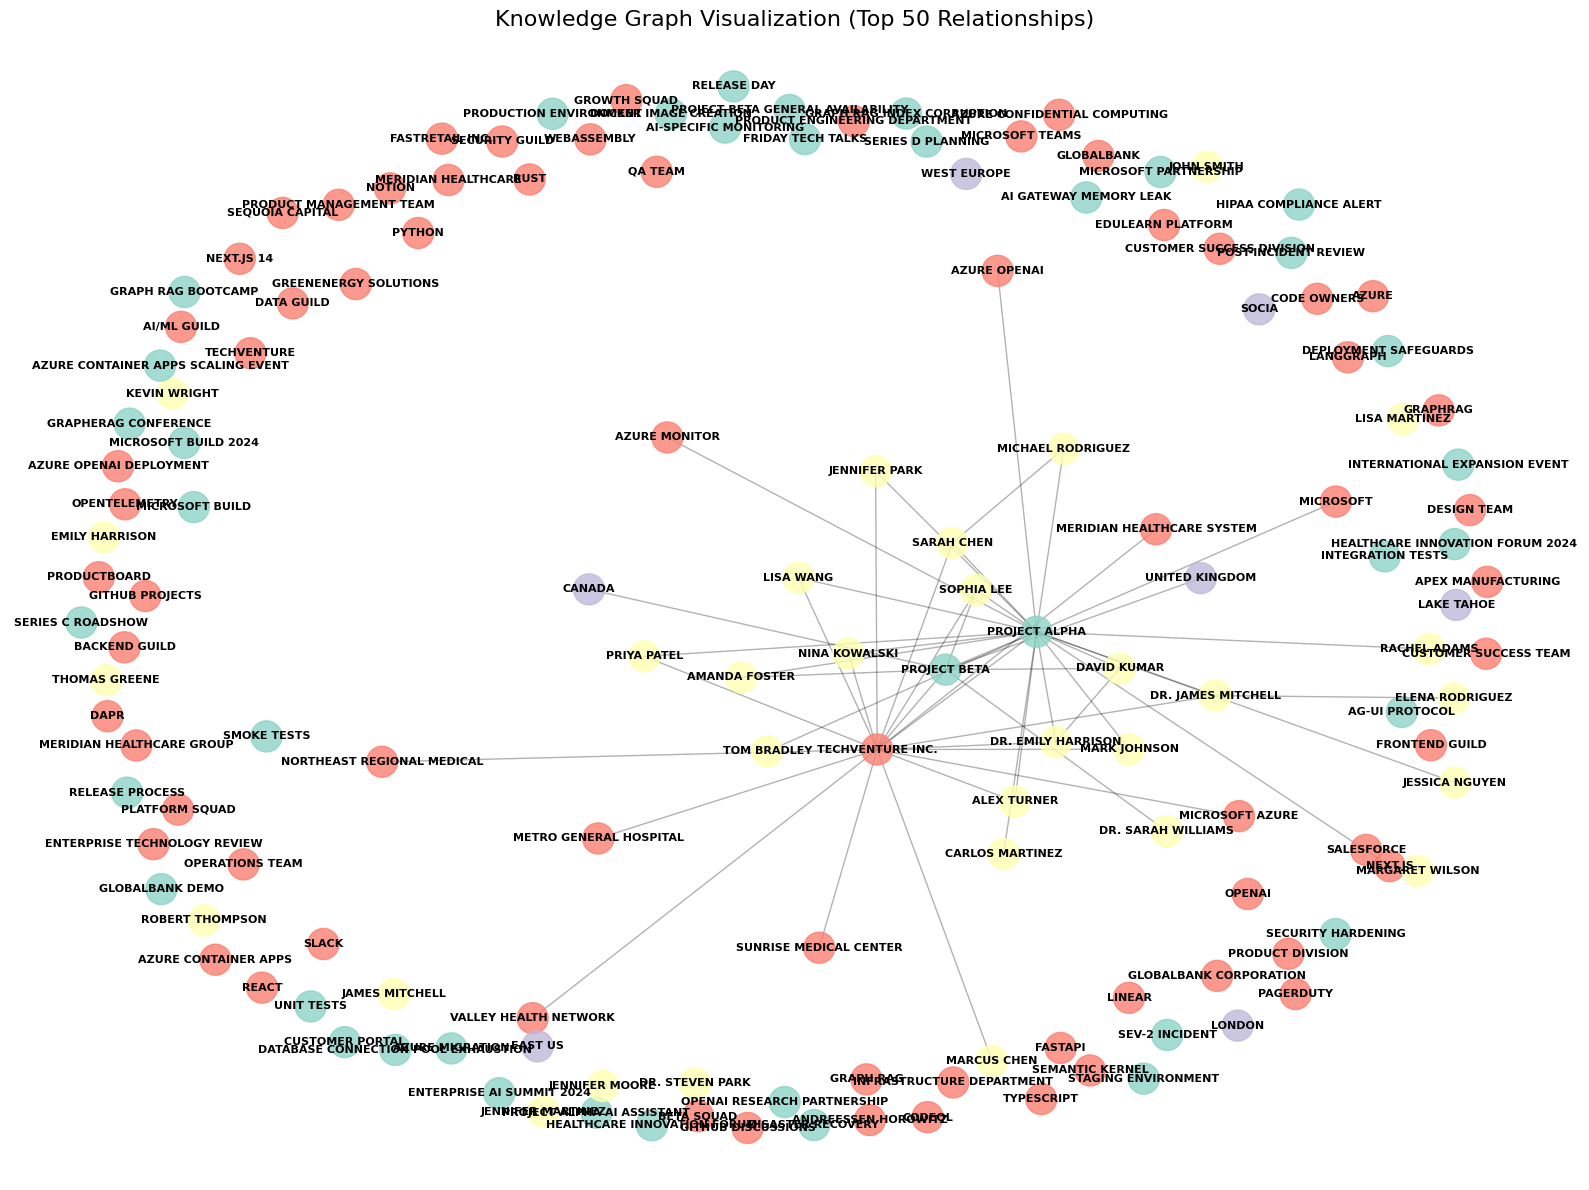


🎨 Legend:
   EVENT: 40 nodes
   PERSON: 31 nodes
   GEO: 7 nodes
   ORGANIZATION: 69 nodes


In [8]:
# Visualize the graph
if G.number_of_nodes() == 0:
    print("⚠️  No nodes to visualize. Check if entities and relationships were loaded correctly.")
else:
    plt.figure(figsize=(16, 12))

    # Use spring layout for positioning
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Color nodes by entity type
    entity_types = entities_df.set_index('title')['type'].to_dict()
    node_colors = [entity_types.get(node, 'unknown') for node in G.nodes()]

    # Create color map
    unique_types = list(set(node_colors))
    color_map = plt.cm.Set3(range(len(unique_types)))
    type_to_color = {t: color_map[i] for i, t in enumerate(unique_types)}
    node_colors_rgb = [type_to_color[t] for t in node_colors]

    # Draw network
    nx.draw_networkx_nodes(G, pos, node_color=node_colors_rgb, node_size=500, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=1)
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    plt.title("Knowledge Graph Visualization (Top 50 Relationships)", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Legend
    print("\n🎨 Legend:")
    for entity_type in unique_types:
        count = sum(1 for t in node_colors if t == entity_type)
        print(f"   {entity_type}: {count} nodes")

## 4. Explore Communities

In [9]:
# Load community reports (GraphRAG 3.x uses community_reports.parquet)
communities_df = pd.read_parquet(output_dir / "community_reports.parquet")

print(f"🏘️  Total Communities: {len(communities_df)}")
print(f"\n📋 Community Levels:")
if 'level' in communities_df.columns:
    print(communities_df['level'].value_counts())
else:
    print("No level information found")

communities_df.head()

🏘️  Total Communities: 32

📋 Community Levels:
level
1    22
0     8
2     2
Name: count, dtype: int64


,id,human_readable_id,community,level,parent,children,title,summary,full_content,rank,rating_explanation,findings,full_content_json,period,size
0,05ff6dbb0032faeda85c8bc3e33cffbca06ade16b9ad8f...,30,30,2,14,[],TechVenture Inc. & GlobalBank Strategic Partne...,"The community encompasses TechVenture Inc., le...",# TechVenture Inc. & GlobalBank Strategic Part...,8.5,The impact severity rating is high due to the ...,"[{'explanation': 'Sarah Chen, the CEO of TechV...","{\n ""title"": ""TechVenture Inc. & GlobalBank...",2026-02-07,3
1,7a2a76a5e82afb9d3ef8b4a75d47ca6a7c96f519562936...,31,31,2,14,[],TechVenture and GlobalBank AI Collaboration,This report outlines the strategic dynamics in...,# TechVenture and GlobalBank AI Collaboration\...,8.0,The impact rating is high due to the strategic...,[{'explanation': 'TechVenture is establishing ...,"{\n ""title"": ""TechVenture and GlobalBank AI...",2026-02-07,4
2,b07421bc53b4f2970e6887262a4a2a1275aad3edc6258f...,8,8,1,1,[],Michael Rodriguez and TechVenture Innovation N...,This community is centered around Michael Rodr...,# Michael Rodriguez and TechVenture Innovation...,8.5,The impact of Michael Rodriguez's leadership a...,[{'explanation': 'Michael Rodriguez plays a cr...,"{\n ""title"": ""Michael Rodriguez and TechVen...",2026-02-07,4
3,30471810be5ea6c20cb21388713d84ab528c41fcb50e72...,9,9,1,1,[],TechVenture Inc. and Project Alpha,The community revolves around TechVenture Inc....,# TechVenture Inc. and Project Alpha\n\nThe co...,8.5,The high impact severity rating reflects TechV...,[{'explanation': 'Project Alpha is the corners...,"{\n ""title"": ""TechVenture Inc. and Project ...",2026-02-07,7
4,1570fe092e0851a13b359c2ab740558ce0922687376d0f...,10,10,1,2,[],TechVenture Inc. Community with Key Figure Jen...,The TechVenture Inc. community is defined by t...,# TechVenture Inc. Community with Key Figure J...,8.5,"TechVenture's community, along with Jennifer P...",[{'explanation': 'Jennifer Park holds a key po...,"{\n ""title"": ""TechVenture Inc. Community wi...",2026-02-07,3


In [10]:
# Show sample community summaries
print("📖 Sample Community Summaries:\n")

for idx, row in communities_df.head(3).iterrows():
    community_id = row.get('community', row.get('id', 'Unknown'))
    level = row.get('level', 'N/A')
    print(f"Community {community_id} (Level {level}):")
    print(f"Title: {row.get('title', 'N/A')}")
    summary = row.get('summary', row.get('full_content', 'N/A'))
    if isinstance(summary, str) and len(summary) > 200:
        print(f"Summary: {summary[:200]}...")
    else:
        print(f"Summary: {summary}")
    print("\n" + "="*60 + "\n")

📖 Sample Community Summaries:

Community 30 (Level 2):
Title: TechVenture Inc. & GlobalBank Strategic Partnership
Summary: The community encompasses TechVenture Inc., led by CEO Sarah Chen, which has developed a significant strategic partnership with GlobalBank. This relationship is characterized by collaborations on inno...


Community 31 (Level 2):
Title: TechVenture and GlobalBank AI Collaboration
Summary: This report outlines the strategic dynamics involving TechVenture, an innovative AI company, and its significant alliances, particularly with GlobalBank Corporation. With its focus on developing advan...


Community 8 (Level 1):
Title: Michael Rodriguez and TechVenture Innovation Network
Summary: This community is centered around Michael Rodriguez, the CTO of TechVenture Inc., and his influential role in steering technology initiatives within the organization and through strategic partnerships...




## 5. Entity Analysis

Find the most connected entities (highest degree centrality).

In [11]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Sort by centrality
top_entities = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("⭐ Top 10 Most Connected Entities:\n")
for entity, centrality in top_entities:
    entity_type = entity_types.get(entity, 'unknown')
    print(f"   {entity} ({entity_type}): {centrality:.3f}")

⭐ Top 10 Most Connected Entities:

   PROJECT ALPHA (EVENT): 0.158
   TECHVENTURE INC. (ORGANIZATION): 0.130
   PROJECT BETA (EVENT): 0.055
   DR. EMILY HARRISON (PERSON): 0.021
   DAVID KUMAR (PERSON): 0.021
   DR. JAMES MITCHELL (PERSON): 0.021
   SOPHIA LEE (PERSON): 0.021
   SARAH CHEN (PERSON): 0.021
   AMANDA FOSTER (PERSON): 0.014
   ALEX TURNER (PERSON): 0.014


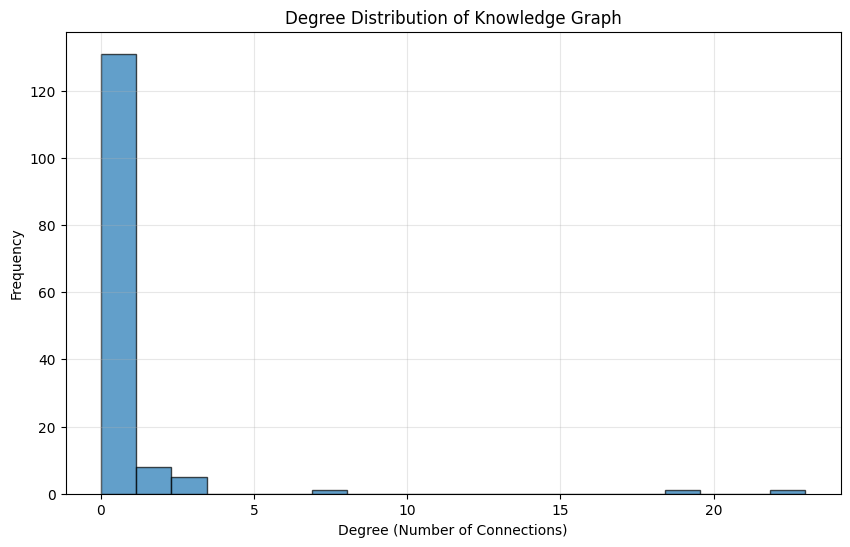


📊 Degree Statistics:
   Mean: 0.68
   Max: 23
   Min: 0


In [12]:
# Visualize degree distribution
degrees = [G.degree(n) for n in G.nodes()]

plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Degree (Number of Connections)')
plt.ylabel('Frequency')
plt.title('Degree Distribution of Knowledge Graph')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n📊 Degree Statistics:")
print(f"   Mean: {sum(degrees)/len(degrees):.2f}")
print(f"   Max: {max(degrees)}")
print(f"   Min: {min(degrees)}")

## 6. Search Examples

Test some search queries (requires running search scripts).

In [13]:
print("💡 Search Queries using Python API:\n")
print("# In terminal:")
print("# Local Search (specific questions):")
print('poetry run python -m core.example "Who leads Project Alpha?"')
print('poetry run python -m core.example "What technologies are used in Project Alpha?"')
print('poetry run python -m core.example "Who resolved the GraphRAG index corruption incident?"')
print("\n# Global Search (thematic questions):")
print('poetry run python -m core.example "What are the main projects?" --type global')
print('poetry run python -m core.example "Summarize the organizational structure" --type global')
print("\n# Or use Python API directly:")
print("""
import asyncio
from core import load_all, local_search, global_search

data = load_all()

# Local search
response, context = asyncio.run(local_search("Who leads Project Alpha?", data))
print(response)

# Global search  
response, context = asyncio.run(global_search("What are the main projects?", data))
print(response)
""")

💡 Search Queries using Python API:

# In terminal:
# Local Search (specific questions):
poetry run python -m core.example "Who leads Project Alpha?"
poetry run python -m core.example "What technologies are used in Project Alpha?"
poetry run python -m core.example "Who resolved the GraphRAG index corruption incident?"

# Global Search (thematic questions):
poetry run python -m core.example "What are the main projects?" --type global
poetry run python -m core.example "Summarize the organizational structure" --type global

# Or use Python API directly:

import asyncio
from core import load_all, local_search, global_search

data = load_all()

# Local search
response, context = asyncio.run(local_search("Who leads Project Alpha?", data))
print(response)

# Global search  
response, context = asyncio.run(global_search("What are the main projects?", data))
print(response)



## Next Steps

1. **Run More Queries:** Try cross-document queries like "Who resolved the GraphRAG index corruption incident?"
2. **Explore Different Entity Types:** Filter the graph by specific entity types
3. **Analyze Specific Communities:** Deep dive into community structures
4. **Add More Documents:** Expand the knowledge graph with additional content

**Python API Reference:**
```python
from core import load_all, local_search, global_search, drift_search, basic_search
```

For Part 2, we'll explore:
- FastMCP server integration
- RESTful API for GraphRAG queries
- Production deployment patterns